# Предиктивный анализ потока абитуриентов на программы НИУ ВШЭ

### Описание

Предскажем с какой вероятность абитуриент поступит в университет на определенную программу после подачи документов в приемную коммисию, а также определим, какие признаки являются наиболее важными при определении этой вероятности. Задав порог вероятности, начиная с которого абитуриент будет зачислен, сможем определить общее число абитуриентов, которые станут студентами НИУ ВШЭ на данной программе.

### Содержание

1. Подготовка данных  
    1.1. Загрузка и предварительное изучение данных  
    1.2. Восстановление целевого признака  
    1.3. Удаление неинформативных признаков и объектов  
    1.4. Изменение названия признаков  
    1.5. Корректировка значений признаков  
    1.6. Изменение типов данных  
    1.7. Работа с дубликатами  
    1.8. Разведочный анализ данных  
    1.9. Работа с пропусками  
    1.10. Работа с признаками  
    1.11. Признак alternatives  
    1.12. Кодирование категориальных признаков  
    1.13. Разбиение выборки  
    1.14. Масштабирование признаков  
2. Баланс классов
3. Моделирование  
    3.1. kNN  
    3.2. Логистическая регрессия  
    3.3. SVM  
    3.4. Решающее дерево  
    3.5. Смешанный лес  
    3.6. Борьба с несбалансированной классификацией  
4. Тестирование модели  
    4.1. Визуализация  
    4.2. Важность признаков  
5. Проверка на адекватность  
6. Вывод  
7. Сохранение модели

### Библиотеки и модули

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, precision_recall_curve, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import joblib

## 1. Подготовка данных 

### 1.1. Загрузка и предварительное изучение данных

In [2]:
path_data = "C:/Users/kiril/OneDrive/Рабочий стол/Дата Саенс/ProjectsDataScience/research_studies/2nd_year_bi/данные/data.xlsx"
path_students = "C:/Users/kiril/OneDrive/Рабочий стол/Дата Саенс/ProjectsDataScience/research_studies/2nd_year_bi/данные/list_of_students.xlsx"

In [3]:
data = pd.read_excel(path_data)
students = pd.read_excel(path_students, header=None)

In [4]:
data.head(5)

,№ п/п,Регистрационный номер,"Фамилия, имя, отчество",Подлинник/Копия документа об образовании,Медаль / диплом с отличием,Право поступления без вступительных испытаний,"Поступление на места в рамках квоты для лиц, имеющих особое право",Поступление на места в рамках квоты целевого приема,Наличие согласия на зачисление,Математика,Иностранный язык,Русский язык,Экзамен 4,Балл за итоговое сочинение,Балл за иные достижения,Итоговая сумма баллов \nпо индивидуальным достижениям,Сумма конкурсных баллов,Дата предоставления подлинника,Форма обучения,Преимущественное право,Требуется общежитие на время обучения,Договор,Договор оплачен,Скидка по сумме баллов ЕГЭ,Возврат документов,Все выбранные конкурсы,Приказ о зачислении,Основание зачисления / выбытия,Гражданство
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,~2708377048~,~2708377224~,~2708377372~,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,948.0,Сидорова Галина Петровна,Подлинник,Нет,30 Межрегиональная экономическая олимпиада шко...,-,-,Да,82,91,96,NaN,8.0,5.0,10.0,279.0,2019-07-22,"Б,К",Нет,-,-,-,70.0,-,"Би (подл.), Эк",№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация
2,2.0,15425.0,Мильчакова Марина Денисовна,Подлинник,Нет,6 Всероссийская олимпиада школьников «Миссия в...,-,-,Да,76,88,96,NaN,8.0,3.0,10.0,270.0,2019-07-11,Б,Нет,-,-,-,70.0,-,Би (подл.),№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация
3,3.0,3246.0,Сейфетдинов Ирфан Маратович,Подлинник,Нет,6 Всероссийская олимпиада школьников «Миссия в...,-,-,Да,82,83,85,NaN,7.0,3.0,10.0,260.0,2019-06-27,Б,Нет,-,-,-,70.0,-,Би (подл.),№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация
4,4.0,16013.0,Серянина Виктория Константиновна,Подлинник,Нет,"50 Олимпиада школьников «Физтех», предмет Мате...",-,-,Да,84,NaN,82,NaN,5.0,3.0,8.0,174.0,2019-07-12,Б,Нет,-,-,-,NaN,-,Би (подл.),№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация


In [5]:
students.head(5)

,0
0,Филимошина Екатерина Романовна
1,Гимадеева Гульнара Мансуровна
2,Клишо Анфиса Сергеевна
3,Лухнев Игорь Дмитриевич
4,Елисеева Екатерина Ильинична


In [6]:
list_of_students = students[0].tolist()
list_of_students

['Филимошина Екатерина Романовна',
 'Гимадеева Гульнара Мансуровна',
 'Клишо Анфиса Сергеевна',
 'Лухнев Игорь Дмитриевич',
 'Елисеева Екатерина Ильинична',
 'Казарян Сергей Айказович',
 'Полищук Анастасия Александровна',
 'Замышляев Роман Филиппович',
 'Куркина Татьяна Андреевна',
 'Гургенадзе Андрей Шотович',
 'Русаков Владислав Андреевич',
 'Антонова Дарья Сергеевна',
 'Лунева Полина Анатольевна',
 'Шипулин Валентин Николаевич',
 'Абдулхаев Камрон Сирожиддинович',
 'Ульданов Дмитрий Сергеевич',
 'Шипулин Максим Николаевич',
 'Юдина Ангелина Вячеславовна',
 'Айвазова Кристина Сергеевна',
 'Дандамаев Саид Артурович',
 'Калякина Мария Алексеевна',
 'Корчагина Елена Алексеевна',
 'Лобанов Павел Юрьевич',
 'Мусина Алина Ильдаровна',
 'Шахалиева Екатерина Владимировна',
 'Шлихт Елизавета Владимировна',
 'Казаева Элина Владиславовна',
 'Сеид-Заде Джаваншир Ильгарович',
 'Сторожок Мария Константиновна',
 'Аршинова Ксения Александровна',
 'Юсупова Арина Ильбаровна',
 'Гусенцова Надежда Андре

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407 entries, 0 to 1406
Data columns (total 29 columns):
№ п/п                                                                1406 non-null float64
Регистрационный номер                                                1406 non-null float64
Фамилия, имя, отчество                                               1406 non-null object
Подлинник/Копия документа об образовании                             1405 non-null object
Медаль / диплом с отличием                                           1406 non-null object
Право поступления без вступительных испытаний                        77 non-null object
Поступление на места в рамках квоты для лиц, имеющих особое право    1406 non-null object
Поступление на места в рамках квоты целевого приема                  1406 non-null object
Наличие согласия на зачисление                                       1406 non-null object
Математика                                                           1400 non-null 

Имеем 1407 объектов. Заметим, что во всех столбцах присутствует хотя бы 1 пропуск, и более одного пропуска в следующих столбцах: Подлинник/Копия документа об образовании, Право поступления без вступительных испытаний, Математика, Иностранный язык, Русский язык, Экзамен 4, Балл за итоговое сочинение, Балл за иные достижения, Итоговая сумма баллов по индивидуальным достижениям, Дата предоставления подлинника, Скидка по сумме баллов ЕГЭ, Приказ о зачислении, Основание зачисления / выбытия. Объект под индексом 0 ноль не несет в себе никакой информации, поэтому удалим его из анализа.  

Что касается признаков, имеем 8 признаков количественного типа, 20 категориального типа и 1 признак временного типа. Заметим, что признаки, которые не несут в себе никакой полезной информации № п/п, Регистрационный номер, поэтому удалим их из нашей таблицы. Также поскольку для поступления на программу Бизнес-информатики необходимо три экзамена, удалим колонку Экзамен 4 (в ней отсутствует какая-либо информация в принципе). Колонка Приказ о зачислении не содержательна, хоть она и является кандидатом на целевой признак, поскольку в ней хранится информация не об всех абитуриентах, которые были зачислены, поэтому ее также удалим из анализа.  

Для дальнейшей комфортной работы переименуем названия признаков.

In [8]:
data.describe()

,№ п/п,Регистрационный номер,Экзамен 4,Балл за итоговое сочинение,Балл за иные достижения,Итоговая сумма баллов \nпо индивидуальным достижениям,Сумма конкурсных баллов,Скидка по сумме баллов ЕГЭ
count,1406.000000,1406.000000,0.0,1302.000000,684.000000,1323.000000,1406.000000,1202.000000
mean,703.500000,9488.229018,NaN,5.488479,3.523392,7.055178,256.051920,60.029118
std,406.021551,5904.948739,NaN,1.320717,0.857851,2.263800,33.947156,16.305881
min,1.000000,5.000000,NaN,1.000000,3.000000,1.000000,0.000000,25.000000
25%,352.250000,4067.250000,NaN,5.000000,3.000000,5.000000,243.000000,50.000000
50%,703.500000,9526.000000,NaN,5.000000,3.000000,7.000000,261.000000,70.000000
75%,1054.750000,14552.000000,NaN,6.000000,4.000000,9.000000,277.000000,70.000000
max,1406.000000,19810.000000,NaN,10.000000,5.000000,10.000000,308.000000,70.000000


### 1.2. Восстановление целевого признака

In [9]:
def target(row):
    student_name = row['Фамилия, имя, отчество']
    if student_name in list_of_students:
        return 1
    return 0

In [10]:
data['target'] = data.apply(target, axis=1)

In [11]:
data.head(5)

,№ п/п,Регистрационный номер,"Фамилия, имя, отчество",Подлинник/Копия документа об образовании,Медаль / диплом с отличием,Право поступления без вступительных испытаний,"Поступление на места в рамках квоты для лиц, имеющих особое право",Поступление на места в рамках квоты целевого приема,Наличие согласия на зачисление,Математика,Иностранный язык,Русский язык,Экзамен 4,Балл за итоговое сочинение,Балл за иные достижения,Итоговая сумма баллов \nпо индивидуальным достижениям,Сумма конкурсных баллов,Дата предоставления подлинника,Форма обучения,Преимущественное право,Требуется общежитие на время обучения,Договор,Договор оплачен,Скидка по сумме баллов ЕГЭ,Возврат документов,Все выбранные конкурсы,Приказ о зачислении,Основание зачисления / выбытия,Гражданство,target
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,~2708377048~,~2708377224~,~2708377372~,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.0,948.0,Сидорова Галина Петровна,Подлинник,Нет,30 Межрегиональная экономическая олимпиада шко...,-,-,Да,82,91,96,NaN,8.0,5.0,10.0,279.0,2019-07-22,"Б,К",Нет,-,-,-,70.0,-,"Би (подл.), Эк",№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация,1
2,2.0,15425.0,Мильчакова Марина Денисовна,Подлинник,Нет,6 Всероссийская олимпиада школьников «Миссия в...,-,-,Да,76,88,96,NaN,8.0,3.0,10.0,270.0,2019-07-11,Б,Нет,-,-,-,70.0,-,Би (подл.),№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация,1
3,3.0,3246.0,Сейфетдинов Ирфан Маратович,Подлинник,Нет,6 Всероссийская олимпиада школьников «Миссия в...,-,-,Да,82,83,85,NaN,7.0,3.0,10.0,260.0,2019-06-27,Б,Нет,-,-,-,70.0,-,Би (подл.),№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация,1
4,4.0,16013.0,Серянина Виктория Константиновна,Подлинник,Нет,"50 Олимпиада школьников «Физтех», предмет Мате...",-,-,Да,84,NaN,82,NaN,5.0,3.0,8.0,174.0,2019-07-12,Б,Нет,-,-,-,NaN,-,Би (подл.),№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация,1


### 1.3. Удаление неинформативных признаков и объектов

In [12]:
data.drop([0], axis=0, inplace=True)
data.head(5)

,№ п/п,Регистрационный номер,"Фамилия, имя, отчество",Подлинник/Копия документа об образовании,Медаль / диплом с отличием,Право поступления без вступительных испытаний,"Поступление на места в рамках квоты для лиц, имеющих особое право",Поступление на места в рамках квоты целевого приема,Наличие согласия на зачисление,Математика,Иностранный язык,Русский язык,Экзамен 4,Балл за итоговое сочинение,Балл за иные достижения,Итоговая сумма баллов \nпо индивидуальным достижениям,Сумма конкурсных баллов,Дата предоставления подлинника,Форма обучения,Преимущественное право,Требуется общежитие на время обучения,Договор,Договор оплачен,Скидка по сумме баллов ЕГЭ,Возврат документов,Все выбранные конкурсы,Приказ о зачислении,Основание зачисления / выбытия,Гражданство,target
1,1.0,948.0,Сидорова Галина Петровна,Подлинник,Нет,30 Межрегиональная экономическая олимпиада шко...,-,-,Да,82,91,96,NaN,8.0,5.0,10.0,279.0,2019-07-22,"Б,К",Нет,-,-,-,70.0,-,"Би (подл.), Эк",№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация,1
2,2.0,15425.0,Мильчакова Марина Денисовна,Подлинник,Нет,6 Всероссийская олимпиада школьников «Миссия в...,-,-,Да,76,88,96,NaN,8.0,3.0,10.0,270.0,2019-07-11,Б,Нет,-,-,-,70.0,-,Би (подл.),№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация,1
3,3.0,3246.0,Сейфетдинов Ирфан Маратович,Подлинник,Нет,6 Всероссийская олимпиада школьников «Миссия в...,-,-,Да,82,83,85,NaN,7.0,3.0,10.0,260.0,2019-06-27,Б,Нет,-,-,-,70.0,-,Би (подл.),№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация,1
4,4.0,16013.0,Серянина Виктория Константиновна,Подлинник,Нет,"50 Олимпиада школьников «Физтех», предмет Мате...",-,-,Да,84,NaN,82,NaN,5.0,3.0,8.0,174.0,2019-07-12,Б,Нет,-,-,-,NaN,-,Би (подл.),№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация,1
5,5.0,8294.0,Новиков Илья Романович,Подлинник,Нет,"46 Олимпиада школьников «Ломоносов», предмет М...",-,-,Да,76,95,70,NaN,8.0,NaN,8.0,249.0,2019-07-03,Б,Нет,+,-,-,50.0,-,"Би (подл.), ЦИУП",№6.18.1-05/2907-64 от 29.07.2019,Зачислен как победитель олимпиады школьников,Российская Федерация,1


In [13]:
data.drop(['№ п/п', 'Регистрационный номер', 'Фамилия, имя, отчество', 'Экзамен 4', 'Приказ о зачислении'], axis=1, inplace=True)
data.head(5)

,Подлинник/Копия документа об образовании,Медаль / диплом с отличием,Право поступления без вступительных испытаний,"Поступление на места в рамках квоты для лиц, имеющих особое право",Поступление на места в рамках квоты целевого приема,Наличие согласия на зачисление,Математика,Иностранный язык,Русский язык,Балл за итоговое сочинение,Балл за иные достижения,Итоговая сумма баллов \nпо индивидуальным достижениям,Сумма конкурсных баллов,Дата предоставления подлинника,Форма обучения,Преимущественное право,Требуется общежитие на время обучения,Договор,Договор оплачен,Скидка по сумме баллов ЕГЭ,Возврат документов,Все выбранные конкурсы,Основание зачисления / выбытия,Гражданство,target
1,Подлинник,Нет,30 Межрегиональная экономическая олимпиада шко...,-,-,Да,82,91,96,8.0,5.0,10.0,279.0,2019-07-22,"Б,К",Нет,-,-,-,70.0,-,"Би (подл.), Эк",Зачислен как победитель олимпиады школьников,Российская Федерация,1
2,Подлинник,Нет,6 Всероссийская олимпиада школьников «Миссия в...,-,-,Да,76,88,96,8.0,3.0,10.0,270.0,2019-07-11,Б,Нет,-,-,-,70.0,-,Би (подл.),Зачислен как победитель олимпиады школьников,Российская Федерация,1
3,Подлинник,Нет,6 Всероссийская олимпиада школьников «Миссия в...,-,-,Да,82,83,85,7.0,3.0,10.0,260.0,2019-06-27,Б,Нет,-,-,-,70.0,-,Би (подл.),Зачислен как победитель олимпиады школьников,Российская Федерация,1
4,Подлинник,Нет,"50 Олимпиада школьников «Физтех», предмет Мате...",-,-,Да,84,NaN,82,5.0,3.0,8.0,174.0,2019-07-12,Б,Нет,-,-,-,NaN,-,Би (подл.),Зачислен как победитель олимпиады школьников,Российская Федерация,1
5,Подлинник,Нет,"46 Олимпиада школьников «Ломоносов», предмет М...",-,-,Да,76,95,70,8.0,NaN,8.0,249.0,2019-07-03,Б,Нет,+,-,-,50.0,-,"Би (подл.), ЦИУП",Зачислен как победитель олимпиады школьников,Российская Федерация,1


### 1.3. Изменение названия признаков

In [14]:
new_column_names = ['is_original', 'is_medal', 'is_olympiad', 'is_quota_special_right', 'is_quota_target_reception', 'is_consent', 'math_points', 'foreign_points', 'russian_points', 'composition_points', 'achievement_points', 'total_individual_points', 'total_points', 'grant_date_original', 'educational_form', 'is_preemptive_right', 'is_dormitory', 'is_contract', 'is_pay_contract', 'discount', 'is_return_contract', 'alternatives', 'reason_for_enrollment', 'citiz', 'target']

In [15]:
data.columns = new_column_names
data.head(5)

,is_original,is_medal,is_olympiad,is_quota_special_right,is_quota_target_reception,is_consent,math_points,foreign_points,russian_points,composition_points,achievement_points,total_individual_points,total_points,grant_date_original,educational_form,is_preemptive_right,is_dormitory,is_contract,is_pay_contract,discount,is_return_contract,alternatives,reason_for_enrollment,citiz,target
1,Подлинник,Нет,30 Межрегиональная экономическая олимпиада шко...,-,-,Да,82,91,96,8.0,5.0,10.0,279.0,2019-07-22,"Б,К",Нет,-,-,-,70.0,-,"Би (подл.), Эк",Зачислен как победитель олимпиады школьников,Российская Федерация,1
2,Подлинник,Нет,6 Всероссийская олимпиада школьников «Миссия в...,-,-,Да,76,88,96,8.0,3.0,10.0,270.0,2019-07-11,Б,Нет,-,-,-,70.0,-,Би (подл.),Зачислен как победитель олимпиады школьников,Российская Федерация,1
3,Подлинник,Нет,6 Всероссийская олимпиада школьников «Миссия в...,-,-,Да,82,83,85,7.0,3.0,10.0,260.0,2019-06-27,Б,Нет,-,-,-,70.0,-,Би (подл.),Зачислен как победитель олимпиады школьников,Российская Федерация,1
4,Подлинник,Нет,"50 Олимпиада школьников «Физтех», предмет Мате...",-,-,Да,84,NaN,82,5.0,3.0,8.0,174.0,2019-07-12,Б,Нет,-,-,-,NaN,-,Би (подл.),Зачислен как победитель олимпиады школьников,Российская Федерация,1
5,Подлинник,Нет,"46 Олимпиада школьников «Ломоносов», предмет М...",-,-,Да,76,95,70,8.0,NaN,8.0,249.0,2019-07-03,Б,Нет,+,-,-,50.0,-,"Би (подл.), ЦИУП",Зачислен как победитель олимпиады школьников,Российская Федерация,1


### 1.4. Корректировка значений признаков

Преобразуем значения бинарных признаков.

In [16]:
def is_original(column):
    if column == 'Подлинник':
        return 1
    return 0

In [17]:
def is_medal(column):
    if column == '+':
        return 1
    return 0

In [18]:
def is_quota_special_right(column):
    if column == '+':
        return 1
    return 0

In [19]:
def is_quota_target_reception(column):
    if column == '+':
        return 1
    return 0

In [20]:
def is_consent(column):
    if column == 'Да':
        return 1
    return 0

In [21]:
def is_preemptive_right(column):
    if column == 'Да':
        return 1
    return 0

In [22]:
def is_dormitory(column):
    if column == '+':
        return 1
    return 0

In [23]:
def is_contract(column):
    if column == '+':
        return 1
    return 0

In [24]:
def is_pay_contract(column):
    if column == '+':
        return 1
    return 0

In [25]:
def is_return_contract(column):
    if column == '+':
        return 1
    return 0

In [26]:
def is_olympiad(column):
    if column == column:
        return 1
    return 0

In [27]:
def correct_binary_features(data):
    data['is_original'] = data['is_original'].apply(is_original)    
    data['is_medal'] = data['is_medal'].apply(is_medal)
    data['is_quota_special_right'] = data['is_quota_special_right'].apply(is_quota_special_right)
    data['is_quota_target_reception'] = data['is_quota_target_reception'].apply(is_quota_target_reception)
    data['is_consent'] = data['is_consent'].apply(is_consent)
    data['is_preemptive_right'] = data['is_preemptive_right'].apply(is_preemptive_right)
    data['is_dormitory'] = data['is_dormitory'].apply(is_dormitory)
    data['is_contract'] = data['is_contract'].apply(is_contract)
    data['is_pay_contract'] = data['is_pay_contract'].apply(is_pay_contract)
    data['is_return_contract'] = data['is_return_contract'].apply(is_return_contract)
    data['is_olympiad'] = data['is_olympiad'].apply(is_olympiad)
    return data

In [28]:
data = correct_binary_features(data)

In [29]:
data.head(5)

,is_original,is_medal,is_olympiad,is_quota_special_right,is_quota_target_reception,is_consent,math_points,foreign_points,russian_points,composition_points,achievement_points,total_individual_points,total_points,grant_date_original,educational_form,is_preemptive_right,is_dormitory,is_contract,is_pay_contract,discount,is_return_contract,alternatives,reason_for_enrollment,citiz,target
1,1,0,1,0,0,1,82,91,96,8.0,5.0,10.0,279.0,2019-07-22,"Б,К",0,0,0,0,70.0,0,"Би (подл.), Эк",Зачислен как победитель олимпиады школьников,Российская Федерация,1
2,1,0,1,0,0,1,76,88,96,8.0,3.0,10.0,270.0,2019-07-11,Б,0,0,0,0,70.0,0,Би (подл.),Зачислен как победитель олимпиады школьников,Российская Федерация,1
3,1,0,1,0,0,1,82,83,85,7.0,3.0,10.0,260.0,2019-06-27,Б,0,0,0,0,70.0,0,Би (подл.),Зачислен как победитель олимпиады школьников,Российская Федерация,1
4,1,0,1,0,0,1,84,NaN,82,5.0,3.0,8.0,174.0,2019-07-12,Б,0,0,0,0,NaN,0,Би (подл.),Зачислен как победитель олимпиады школьников,Российская Федерация,1
5,1,0,1,0,0,1,76,95,70,8.0,NaN,8.0,249.0,2019-07-03,Б,0,1,0,0,50.0,0,"Би (подл.), ЦИУП",Зачислен как победитель олимпиады школьников,Российская Федерация,1


### 1.5. Изменение типов данных

In [30]:
data.dtypes

is_original                           int64
is_medal                              int64
is_olympiad                           int64
is_quota_special_right                int64
is_quota_target_reception             int64
is_consent                            int64
math_points                          object
foreign_points                       object
russian_points                       object
composition_points                  float64
achievement_points                  float64
total_individual_points             float64
total_points                        float64
grant_date_original          datetime64[ns]
educational_form                     object
is_preemptive_right                   int64
is_dormitory                          int64
is_contract                           int64
is_pay_contract                       int64
discount                            float64
is_return_contract                    int64
alternatives                         object
reason_for_enrollment           

Все признаки относятся к соответствующим типом кроме math_points, foreign_points, russian_points и discount. Первые три прочитались как категориальные, а на самом деле они являются количественными переменными.

In [31]:
for i in ['math_points', 'foreign_points', 'russian_points']:
    data[i] = pd.to_numeric(data[i], errors='coerce')

In [32]:
data.dtypes

is_original                           int64
is_medal                              int64
is_olympiad                           int64
is_quota_special_right                int64
is_quota_target_reception             int64
is_consent                            int64
math_points                         float64
foreign_points                      float64
russian_points                      float64
composition_points                  float64
achievement_points                  float64
total_individual_points             float64
total_points                        float64
grant_date_original          datetime64[ns]
educational_form                     object
is_preemptive_right                   int64
is_dormitory                          int64
is_contract                           int64
is_pay_contract                       int64
discount                            float64
is_return_contract                    int64
alternatives                         object
reason_for_enrollment           

Проведем оптимизацию памяти с помощью изменения типов данных.

In [33]:
"""
Функция для подсчета использования памяти каким-либо типом данных.
"""

def mem_usage(pd_obj):
    if isinstance(pd_obj, pd.DataFrame):
        usage_b = pd_obj.memory_usage(deep=True).sum()
    else:
        usage_b = pd_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2
    return "{:03.2f} MB".format(usage_mb)

Оптимизируем числовые типы

In [34]:
data_int = data.select_dtypes(include=['int64']) # для данных типов int
converted_int = data_int.apply(pd.to_numeric, downcast='unsigned')

print(f'Было: {mem_usage(data_int)}')
print(f'Стало: {mem_usage(converted_int)}')

Было: 0.14 MB
Стало: 0.03 MB


In [35]:
data_float = data.select_dtypes(include=['float'])
converted_float = data_float.apply(pd.to_numeric, downcast='float')

print(f'Было: {mem_usage(data_float)}')
print(f'Стало: {mem_usage(converted_float)}')

Было: 0.10 MB
Стало: 0.05 MB


In [36]:
data_old = data
data = data_old.copy()

data[converted_int.columns] = converted_int
data[converted_float.columns] = converted_float

Оптимизировать категориальные не будем во избежание каких-либо проблем работы с данными.

Посомотрим, как изменился объем памяти хранения данных.

In [37]:
print(f'Было: {mem_usage(data_old)}')
print(f'Стало: {mem_usage(data)}')

Было: 0.73 MB
Стало: 0.58 MB


In [38]:
data.dtypes

is_original                           uint8
is_medal                              uint8
is_olympiad                           uint8
is_quota_special_right                uint8
is_quota_target_reception             uint8
is_consent                            uint8
math_points                         float32
foreign_points                      float32
russian_points                      float32
composition_points                  float32
achievement_points                  float32
total_individual_points             float32
total_points                        float32
grant_date_original          datetime64[ns]
educational_form                     object
is_preemptive_right                   uint8
is_dormitory                          uint8
is_contract                           uint8
is_pay_contract                       uint8
discount                            float32
is_return_contract                    uint8
alternatives                         object
reason_for_enrollment           

Переменная discount являет по сути категориальной переменной, поскольку принимает только значения: 70, 50, 25 и 0.

In [39]:
data['discount'] = data['discount'].astype('object')

### 1.6. Работа с дубликатами

In [40]:
data.duplicated().sum()

0

В таблице отсутствуют дубликаты.

### 1.7. Разведочный анализ данных

Рассмотрим корреляцию между признаками.

In [41]:
data.corr()

,is_original,is_medal,is_olympiad,is_quota_special_right,is_quota_target_reception,is_consent,math_points,foreign_points,russian_points,composition_points,achievement_points,total_individual_points,total_points,is_preemptive_right,is_dormitory,is_contract,is_pay_contract,is_return_contract,target
is_original,1.000000,-0.020073,0.452592,0.038089,0.050163,0.962245,0.034507,-0.052571,-0.105333,-0.001898,0.028166,-0.074728,-0.142772,-0.062246,-0.001354,0.684473,0.635549,-0.042687,0.891920
is_medal,-0.020073,1.000000,-0.009085,-0.005281,-0.001007,-0.020860,-0.001172,-0.014535,0.031332,0.000342,0.030109,0.042038,-0.085141,-0.004417,-0.027475,-0.015593,-0.013620,-0.003029,-0.020984
is_olympiad,0.452592,-0.009085,1.000000,-0.033681,-0.006422,0.435505,0.168765,-0.082482,-0.117434,0.047730,0.083132,-0.017818,-0.309515,-0.028172,0.146700,-0.081730,-0.067281,-0.019320,0.403486
is_quota_special_right,0.038089,-0.005281,-0.033681,1.000000,-0.003733,0.032831,-0.034821,-0.009844,-0.022790,-0.045678,-0.040079,-0.017693,0.004978,-0.016377,0.017949,-0.043125,-0.034264,-0.011231,0.032025
is_quota_target_reception,0.050163,-0.001007,-0.006422,-0.003733,1.000000,0.048269,0.010792,0.012448,0.031332,0.031742,-0.023363,0.035791,0.021186,-0.003122,0.036648,0.064574,0.073929,-0.002141,0.047984
is_consent,0.962245,-0.020860,0.435505,0.032831,0.048269,1.000000,0.031323,-0.056274,-0.102574,-0.000173,0.017830,-0.081007,-0.136587,-0.064689,-0.013970,0.747507,0.652916,-0.044362,0.899151
math_points,0.034507,-0.001172,0.168765,-0.034821,0.010792,0.031323,1.000000,0.308168,0.423617,0.221948,0.223945,0.337495,0.482381,-0.029716,0.156074,-0.134027,-0.133017,-0.019973,0.031799
foreign_points,-0.052571,-0.014535,-0.082482,-0.009844,0.012448,-0.056274,0.308168,1.000000,0.459491,0.217156,0.054299,0.266300,0.741420,-0.067943,-0.000795,-0.084370,-0.082989,0.018245,-0.049560
russian_points,-0.105333,0.031332,-0.117434,-0.022790,0.031332,-0.102574,0.423617,0.459491,1.000000,0.283499,0.053564,0.386091,0.687017,-0.026955,0.135548,-0.095384,-0.107791,-0.025325,-0.092121
composition_points,-0.001898,0.000342,0.047730,-0.045678,0.031742,-0.000173,0.221948,0.217156,0.283499,1.000000,0.032376,0.656457,0.287499,-0.043808,0.080109,-0.057871,-0.076684,-0.021648,0.018627


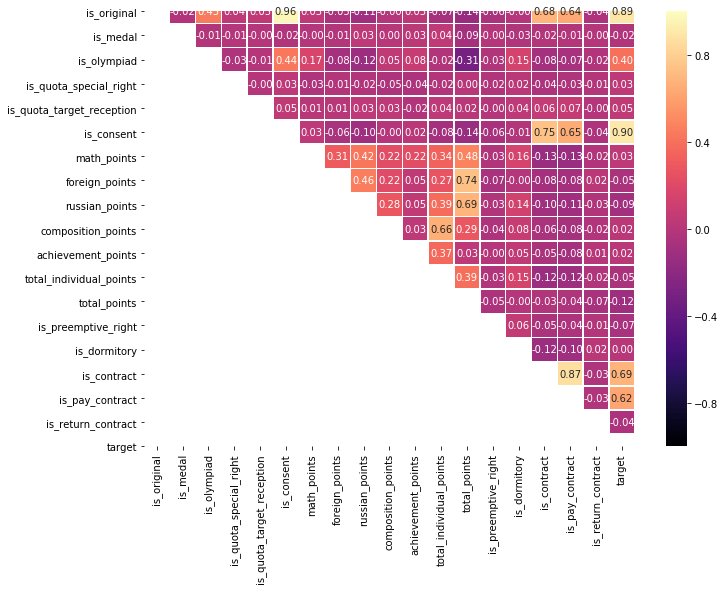

In [42]:
mask = np.tril(data.corr())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sns.heatmap(data.corr(), linewidth=.5, annot=True, fmt='.2f', vmax=1, vmin=-1, center=0, cmap='magma', linecolor='white', mask=mask, ax=ax)
plt.show()

Очевидно, что признак total_points можем выразить путем сложения math_points, russian_points, foreign_points, total_individual_points, а total_individual_points через composition_points, achievement_points.

Такое выржение переменных друг через друга приводит к проблеме **мультиколлинеарности**, которая в свою очередь является причиной переобучения, увеличения сложности и ненадежности результатов модели. Возможны следующие варианты:
1. оставить признаки math_points, russian_points, foreign_points, composition_points, achievement_points;
2. создать признак state_exam_points и оставить признак total_individual_points;
3. оставить признак total_points;
4. оставить признаки math_points, russian_points, foreign_points, total_individual_points.

Посмотрим на распределения количественных признаков.

In [43]:
data_for_dist = data[['math_points', 'russian_points', 'foreign_points', 'composition_points', 'achievement_points', 'discount', 'total_points', 'total_individual_points', 'target']]

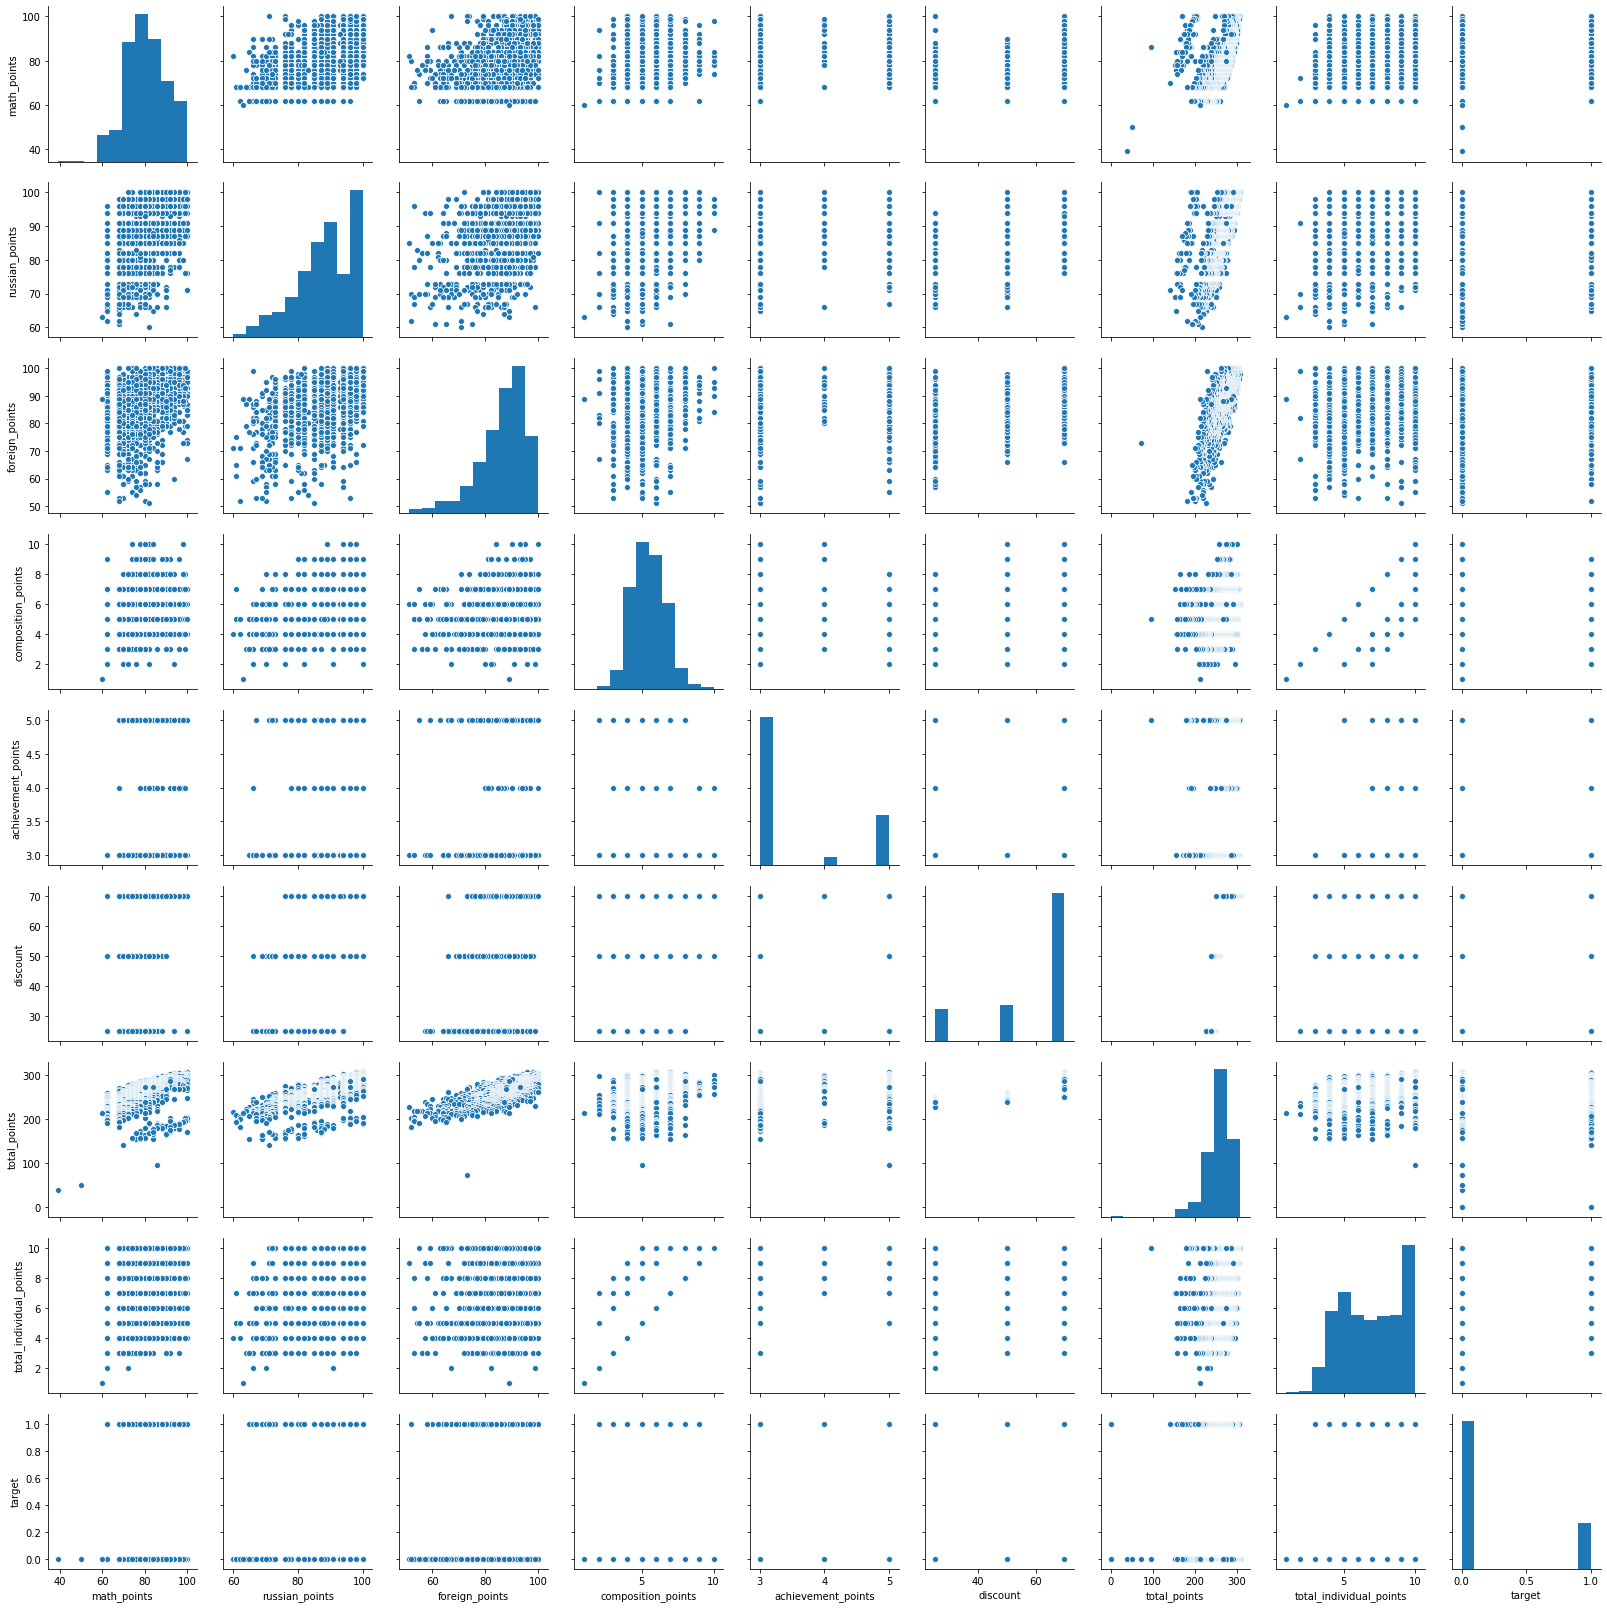

In [44]:
sns.pairplot(data_for_dist)
plt.show()

По распределению целевой переменной видим, что мы имеем дело с **несбалансированной классификацией**. Заметим, что распределения независимых количественных признаков total_points, composition_points, math_points похоже на **нормальное**. Признаки russian_points и foreign_points **скошены влево**. А распределение признака total_individual_points **равномерное**.

### 1.9. Работа с пропусками

In [45]:
data.isnull().sum()

is_original                     0
is_medal                        0
is_olympiad                     0
is_quota_special_right          0
is_quota_target_reception       0
is_consent                      0
math_points                     7
foreign_points                 71
russian_points                 10
composition_points            104
achievement_points            722
total_individual_points        83
total_points                    0
grant_date_original          1095
educational_form                0
is_preemptive_right             0
is_dormitory                    0
is_contract                     0
is_pay_contract                 0
discount                      204
is_return_contract              0
alternatives                    0
reason_for_enrollment        1316
citiz                           0
target                          0
dtype: int64

In [46]:
data.isnull().sum() / data.shape[0] * 100

is_original                   0.000000
is_medal                      0.000000
is_olympiad                   0.000000
is_quota_special_right        0.000000
is_quota_target_reception     0.000000
is_consent                    0.000000
math_points                   0.497866
foreign_points                5.049787
russian_points                0.711238
composition_points            7.396871
achievement_points           51.351351
total_individual_points       5.903272
total_points                  0.000000
grant_date_original          77.880512
educational_form              0.000000
is_preemptive_right           0.000000
is_dormitory                  0.000000
is_contract                   0.000000
is_pay_contract               0.000000
discount                     14.509246
is_return_contract            0.000000
alternatives                  0.000000
reason_for_enrollment        93.598862
citiz                         0.000000
target                        0.000000
dtype: float64

#### math_points, foreign_points, russian_points, composition_points, achievement_points, total_individual_points

Пропуски в данных переменных связаны с тем, что это означает отсутствие баллов, поэтому все пропуски в этих признаках заполним 0.

In [47]:
some_list = ['math_points', 'foreign_points', 'russian_points', 'composition_points', 'achievement_points', 'total_individual_points']

In [48]:
for column in some_list:
    data.loc[data[column].isnull() == True, column] = 0

#### grant_date_original

Наличие пропущенных значений в данной переменной связано с тем, что то, что абитуриент не принес подлинник никак не отмечалось. Важно ли нам то, когда абитуриент принес подлинник? На самом деле нет. Сам факт того, что был принесен подлинник, в целом говорит об его уверенности, поэтому то, когда было сделано не так важно.

Удалим этот признак из анализа.

In [49]:
data = data.drop(['grant_date_original'], axis=1)

#### discount

Наличие пропуска в поле скидки лишь также означает, что значени не было проставлен для тех случаев, когда по определенной сумме баллов ЕГЭ скидка не предоставляется. Заполним его нулевым значением.

In [50]:
data.loc[data['discount'].isnull() == True, 'discount'] = 0

#### reason_for_enrollment

Пропуски в данном признаке означают, что абитуриенты, которые пошли учиться по коммерции, никак дополнительно не отмечали. На самом деле значения данного признака повторяют уже существующие признаки в нашей таблице. Так:
1. Зачислен как победитель олимпиады школьников - name_olympiads;
2. Зачислен вне конкурса по федеральным льготам - is_quota_special_right;
3. Зачислен по целевому набору - is_quota_target_reception.

Поэтому данный признак не несет никакой новой информации, он избыточный, можем его удалить из рассмотрения.

In [51]:
data = data.drop(['reason_for_enrollment'], axis=1)

#### Итог

In [52]:
data.isnull().sum()

is_original                  0
is_medal                     0
is_olympiad                  0
is_quota_special_right       0
is_quota_target_reception    0
is_consent                   0
math_points                  0
foreign_points               0
russian_points               0
composition_points           0
achievement_points           0
total_individual_points      0
total_points                 0
educational_form             0
is_preemptive_right          0
is_dormitory                 0
is_contract                  0
is_pay_contract              0
discount                     0
is_return_contract           0
alternatives                 0
citiz                        0
target                       0
dtype: int64

Проблема с пропусками решена.

### 1.10. Работа с признаками

Цель данного шага убрать избыточные, неинформативные признаки, а также те признаки, которые выражются через другие.

Снова рассмотрим матрицу корреляций.

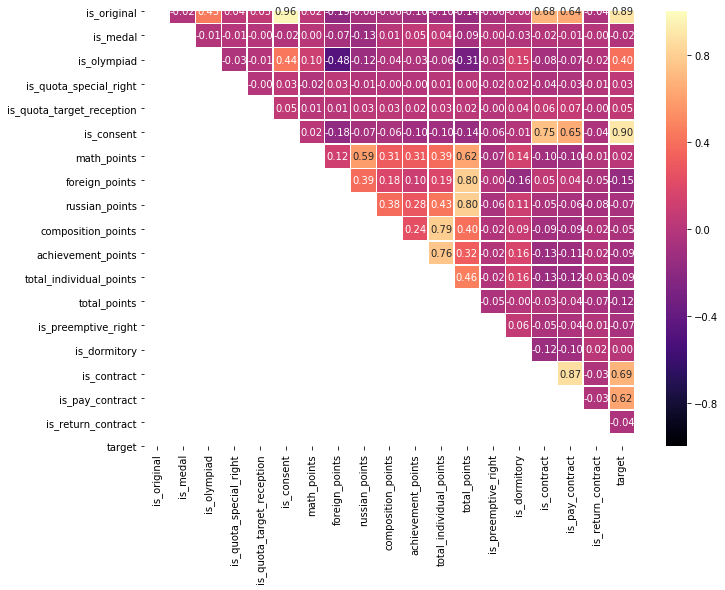

In [53]:
mask = np.tril(data.corr())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sns.heatmap(data.corr(), linewidth=.5, annot=True, fmt='.2f', vmax=1, vmin=-1, center=0, cmap='magma', linecolor='white', mask=mask, ax=ax)
fig.savefig('C:/Users/kiril/OneDrive/Рабочий стол/Дата Саенс/ProjectsDataScience/research_studies/2nd_year_bi/графики/corr_1.png')
plt.show()

Очевидная связь между тем дал ли свое согласие абитуриент и принес ли подлинник. Если он принес подлинник, значит он и согласен. Уберем признак is_consent из анализа.

In [54]:
data = data.drop(['is_consent'], axis=1)

Признаки is_contract и is_pay_contract являются по больше частью также повторением признака is_original. Поскольку если человек принес подлинник, то это говорит о том, что он подписал договор и также, что вероятнее всего он его оплатит (мы не можем знать об этом однозначно на начало момента подачи документов). Поэтому эти переменные не несут в себе какой-либо полезной информации, а значит можем их убрать из нашего анализа.

In [55]:
data = data.drop(['is_contract', 'is_pay_contract'], axis=1)

Решая проблему мультиколлинерности, оставим признаки math_points, russian_points, foreign_points, total_individual_points и discounts (4 вариант).

In [56]:
data = data.drop(['total_points', 'composition_points', 'achievement_points'], axis=1)

Столбец educational_form не несет в себе значимой информации, поскольку в нем есть значение Б,К, что не дает информации о том, учится студент на коммерции или бюджете. Поэтом удалим данный признак.

In [57]:
data = data.drop(['educational_form'], axis=1)

Таким образом, получаем следующую таблицу.

In [58]:
data.head(2)

,is_original,is_medal,is_olympiad,is_quota_special_right,is_quota_target_reception,math_points,foreign_points,russian_points,total_individual_points,is_preemptive_right,is_dormitory,discount,is_return_contract,alternatives,citiz,target
1,1,0,1,0,0,82.0,91.0,96.0,10.0,0,0,70,0,"Би (подл.), Эк",Российская Федерация,1
2,1,0,1,0,0,76.0,88.0,96.0,10.0,0,0,70,0,Би (подл.),Российская Федерация,1


### 1.11. Признак alternatives

Данный признак является наиболее интересным. Для каждого абитуриента указаны возможные альтернативы поступления.

Возьмем все возможные уникальные значения. Далее каждая альтернатива будет отдельным признаком, где если абитуриент рассматривал ее, то 1, иначе 0.

In [59]:
list_of_alternatives = []
for i in tqdm(range(data.shape[0])):
    i_alternatives = data.loc[i + 1, 'alternatives'].split(',')
    for j in i_alternatives:
        list_of_alternatives.append(j.strip(' '))

100%|███████████████████████████████████████████████████████████████████████████| 1406/1406 [00:00<00:00, 93971.66it/s]


In [60]:
list_of_alternatives_uniq = list(set(list_of_alternatives))

In [61]:
a = ['a', 'b']

In [62]:
' '.join(a)

'a b'

In [63]:
list_of_alternatives_uniq

['ЭиПА',
 'УБ (подл.)',
 'Физ',
 'СПБ ЛУЦП',
 'СПБ ПМИН',
 'ИТСС',
 'Марк',
 'Марк (подл.)',
 'Эк',
 'ПИНЖ (подл.)',
 'ПИ',
 'МИЭФ (подл.)',
 'СПБ ССИН (подл.)',
 'Полит',
 'ЦПМ',
 'ЦИУП (подл.)',
 'ИВТ (подл.)',
 'Ант (Ист)',
 'Би',
 'СПБ ЛУЦП (подл.)',
 'УПРБ (подл.)',
 'МИЭФ',
 'Азия',
 'НН Мат',
 'Жур',
 'Хим',
 'КБ',
 'НН ФИПЛ',
 'НН БИ (подл.)',
 'Юр',
 'УБ',
 'Ист (подл.)',
 'Яп',
 'Ст (подл.)',
 'Рекл (подл.)',
 'Лог (подл.)',
 'Ист',
 'ПМ',
 'РЭШ',
 'Ст',
 'Гор',
 'УПРБ',
 'Соц (подл.)',
 'Фил',
 'Био',
 'ПИНЖ',
 'БИИН',
 'СПБ ВВЕД',
 'КБ (подл.)',
 'МОЛ',
 'ПМ (подл.)',
 'СПБ ССИН',
 'МирЭк',
 'НН Э (подл.)',
 'Эк (подл.)',
 'НН ПМИ',
 'ПМиИ',
 'ЭКОН',
 'НН Э',
 'СПБ ДИЗН',
 'СПБ ЭКОН',
 'ПИ (подл.)',
 'СПБ ЭКОН (подл.)',
 'Иностр (подл.)',
 'БИИН (подл.)',
 'СПБ МБМН',
 'СПБ ПМИН (подл.)',
 'Диз (подл.)',
 'ЭКОН (подл.)',
 'Соц',
 'ИБ',
 'Мат',
 'ИВТ',
 'Медиа',
 'ПРАД',
 'ЮРПР',
 'МО',
 'НН ПИ',
 'МирЭк (подл.)',
 'ГМУ (подл.)',
 'ПРАД (подл.)',
 'ЦИУП',
 'НН БИ',
 'МО-Л',


In [64]:
alternatives = []

In [65]:
for i in list_of_alternatives_uniq:
    i_split = i.split(' ')
    for j in range(len(i_split)):
        if i_split[j] == '(подл.)':
            i_split.pop(j)
    alternatives.append(' '.join(i_split))

In [66]:
alternatives = list(set(alternatives))

In [67]:
print(alternatives)

['НН ФИПЛ', 'НН ПМИ', 'Асс', 'ЭиПА', 'ПМиИ', 'НН Э', 'ЭКОН', 'Физ', 'Юр', 'Лог', 'УБ', 'СПБ ЛУЦП', 'СПБ ДИЗН', 'СПБ ЭКОН', 'СПБ ПМИН', 'Яп', 'ИТСС', 'Марк', 'СоврИ', 'СПБ МБМН', 'Эк', 'Вост', 'КБ', 'ПИ', 'Ист', 'Соц', 'ПМ', 'Рекл', 'НН УБ', 'РЭШ', 'Ст', 'ИБ', 'Мат', 'Диз', 'ИВТ', 'Медиа', 'Пс', 'Гор', 'ПРАД', 'УПРБ', 'ЮРПР', 'СПБ УАГС', 'Полит', 'МО', 'НН ПИ', 'Фил', 'Био', 'ПИНЖ', 'ЦПМ', 'Ант (Ист)', 'БИИН', 'Би', 'Лингв', 'ГМУ', 'СПБ ВВЕД', 'МИЭФ', 'Азия', 'МОЛ', 'ЧастП', 'НН Мат', 'Жур', 'ЦИУП', 'Хим', 'СПБ ССИН', 'Иностр', 'МирЭк', 'НН БИ', 'МО-Л']


In [68]:
len(alternatives)

68

Выходит достаточно большое количество альтернатив. Попробуем их разбить на следующие группы:
1. другие программы НИУ ВШЭ в Москве;
2. другие кампусы НИУ ВШЭ;
3. другие ВУЗЫ;
4. не рассматривал альтернатив.

In [69]:
hse_moscow_alternatives = ['СоврИ', 'Гор', 'ГМУ', 'ЮРПР', 'КБ', 'Пс', 'Мат', 'МО', 'Фил', 'Рекл', 'Ист', 'Юр', 'Иностр', 'Соц', 'ЧастП', 'Марк', 'Физ', 'Эк', 'МОЛ', 'ИТСС', 'ИВТ', 'ЭКОН', 'Лингв', 'Азия', 'Био', 'ПМ', 'ПМиИ', 'ИБ', 'Ант (Ист)', 'УБ', 'Полит', 'ПИНЖ', 'Хим', 'МирЭк', 'МИЭФ', 'ЦПМ', 'ПРАД', 'Диз', 'ЦИУП', 'Медиа', 'Жур', 'ЭиПА', 'Лог', 'УПРБ', 'МО-Л', 'Яп', 'Ст', 'БИИН', 'РЭШ', 'ПИ', 'Вост', 'Асс']

In [70]:
hse_other_campuses = ['НН', 'СПБ']

In [71]:
def hse_moscow(column):
    for moscow_alternative in hse_moscow_alternatives:
        if moscow_alternative in column:
            return 1
    return 0

In [72]:
def hse_campuses(column):
    for moscow_campus in hse_other_campuses:
        if moscow_campus in column:
            return 1
    return 0

In [73]:
def no_alternatives(column):
    if column in ['Би', 'Би(подл.)']:
        return 1
    return 0

К сожалению, информации по другим ВУЗам нет.

In [74]:
def alternatives(data):
    data['hse_moscow_alternatives'] = data['alternatives'].apply(hse_moscow)
    data['hse_campus_alternatives'] = data['alternatives'].apply(hse_campuses)
    data['no_alternatives'] = data['alternatives'].apply(no_alternatives)
    return data

In [75]:
data = alternatives(data)

In [76]:
data

,is_original,is_medal,is_olympiad,is_quota_special_right,is_quota_target_reception,math_points,foreign_points,russian_points,total_individual_points,is_preemptive_right,is_dormitory,discount,is_return_contract,alternatives,citiz,target,hse_moscow_alternatives,hse_campus_alternatives,no_alternatives
1,1,0,1,0,0,82.0,91.0,96.0,10.0,0,0,70,0,"Би (подл.), Эк",Российская Федерация,1,1,0,0
2,1,0,1,0,0,76.0,88.0,96.0,10.0,0,0,70,0,Би (подл.),Российская Федерация,1,0,0,0
3,1,0,1,0,0,82.0,83.0,85.0,10.0,0,0,70,0,Би (подл.),Российская Федерация,1,0,0,0
4,1,0,1,0,0,84.0,0.0,82.0,8.0,0,0,0,0,Би (подл.),Российская Федерация,1,0,0,0
5,1,0,1,0,0,76.0,95.0,70.0,8.0,0,1,50,0,"Би (подл.), ЦИУП",Российская Федерация,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,0,0,0,0,0,90.0,88.0,85.0,5.0,0,1,70,1,"Эк, Би, Лингв",Российская Федерация,0,1,0,0
1403,0,0,0,0,0,80.0,87.0,67.0,6.0,0,0,25,1,"Би, ЦИУП, МИЭФ",Российская Федерация,0,1,0,0
1404,0,0,0,0,0,60.0,89.0,63.0,1.0,0,0,0,1,"ЦИУП, Би, Лог",Российская Федерация,0,1,0,0
1405,0,0,0,0,0,74.0,0.0,80.0,4.0,0,0,0,1,"Би, ИВТ, ПИ",Российская Федерация,0,1,0,0


In [77]:
data.drop(['alternatives'], axis=1, inplace=True)

In [78]:
data.head(2)

,is_original,is_medal,is_olympiad,is_quota_special_right,is_quota_target_reception,math_points,foreign_points,russian_points,total_individual_points,is_preemptive_right,is_dormitory,discount,is_return_contract,citiz,target,hse_moscow_alternatives,hse_campus_alternatives,no_alternatives
1,1,0,1,0,0,82.0,91.0,96.0,10.0,0,0,70,0,Российская Федерация,1,1,0,0
2,1,0,1,0,0,76.0,88.0,96.0,10.0,0,0,70,0,Российская Федерация,1,0,0,0


### 1.12. Кодирование категориальных признаков

Поскольку задача классификации метод Mean-Target Encoding не подойдет. Рассмотрим One-Hot Encoding подход.

In [79]:
data = pd.get_dummies(data, drop_first=True)

In [80]:
data.head(2)

,is_original,is_medal,is_olympiad,is_quota_special_right,is_quota_target_reception,math_points,foreign_points,russian_points,total_individual_points,is_preemptive_right,is_dormitory,is_return_contract,target,hse_moscow_alternatives,hse_campus_alternatives,no_alternatives,discount_25.0,discount_50.0,discount_70.0,citiz_Армения,citiz_Государство Израиль,citiz_Демократическая Республика Конго,citiz_Латвия,citiz_Республика Беларусь,citiz_Республика Ирак,citiz_Республика Казахстан,citiz_Российская Федерация,citiz_Социалистическая Республика Вьетнам
1,1,0,1,0,0,82.0,91.0,96.0,10.0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,0,1,0,0,76.0,88.0,96.0,10.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


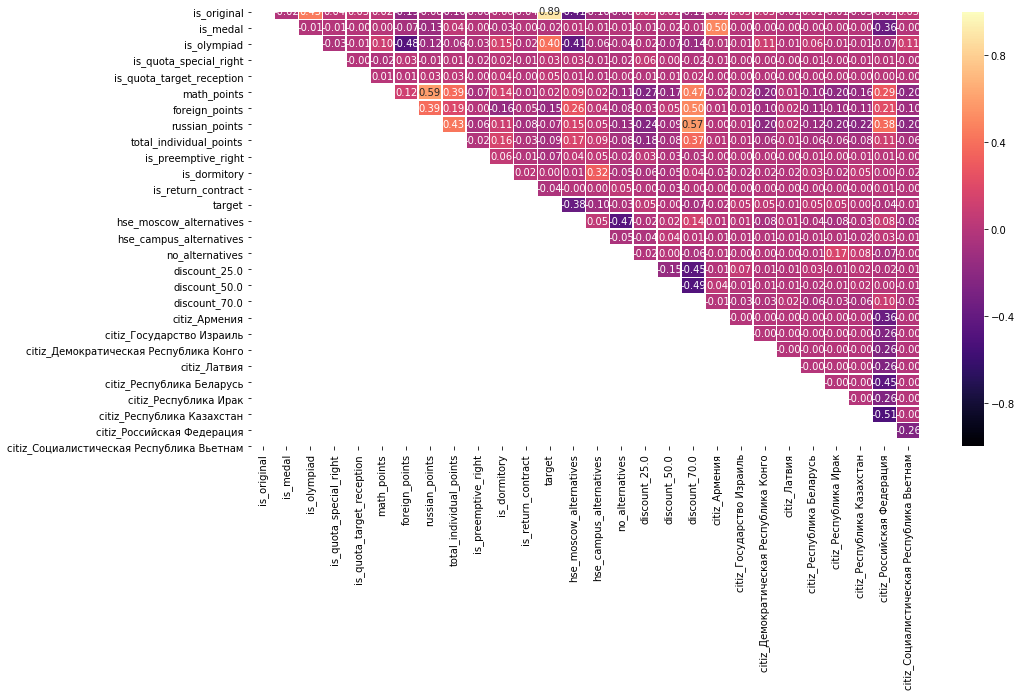

In [81]:
mask = np.tril(data.corr())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
sns.heatmap(data.corr(), linewidth=.5, annot=True, fmt='.2f', vmax=1, vmin=-1, center=0, cmap='magma', linecolor='white', mask=mask, ax=ax)
fig.savefig('C:/Users/kiril/OneDrive/Рабочий стол/Дата Саенс/ProjectsDataScience/research_studies/2nd_year_bi/графики/corr_2.png')
plt.show()

### 1.13. Разбиение выборки

Разобьем выборку на две части: тренировочную и тестовую. Валидационная выборка будет выделяться при использовании метода кросс-валидации во время обучения.

In [82]:
y = data['target']
X = data.drop(['target'], axis=1)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

### 1.14. Масштабирование признаков

Проводим масштабирование признаков с помощью стандартизации.

In [84]:
X_columns = X_train.columns.tolist()

In [85]:
st_scaler = StandardScaler()
st_scaler.fit(X_train[X_columns])
X_train[X_columns] = st_scaler.transform(X_train[X_columns])
X_test[X_columns] = st_scaler.transform(X_test[X_columns])

## 2. Баланс классов

Ранее заметили, что в целевой переменной присутствует дисбаланс классов.

In [86]:
class_freq = y_train.value_counts(normalize=True)

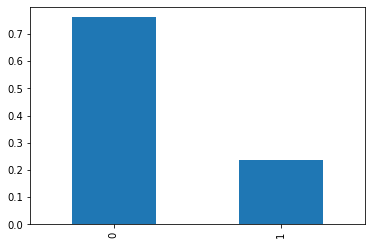

In [87]:
fig, ax = plt.subplots()
class_freq.plot(kind='bar', ax=ax)
fig.savefig('C:/Users/kiril/OneDrive/Рабочий стол/Дата Саенс/ProjectsDataScience/research_studies/2nd_year_bi/графики/disbalanc.png')
plt.show()

Объектов нулевого класса встречается в более чем в 2 раза больше, чем объектов первого класса.

Дисбаланс классов приводит к тому, что модель плохо обучается на одних объектах и лучше на других. Чтобы этого не допустить необходимо, чтобы соотношение объектов классов было примерно равно.

**Методы борьбы с дисбалансом классов:**
- взвешивание классов;
- увеличение выборки (upsampling);
- уменьшение выборки (downsampling);
- изменение порога вероятности.

Чтобы определить лучший подход, необходимо рассмотреть все варианты и выбрать тот, при котором алгоритм выдает лучшее качество. Однако можем исключить подход уменьшения выборки, так как он уместен при работе с большим количеством данных. При работе на малом количестве данных он только привед к недообучению моделей из-за исключения данных.

## 3. Моделирование

Рассмотрим следующие модели: kNN, Logisitic Regression, Decision Tree, Random Forest.

При построении моделей будем использовать кросс-валидацию для получения более качественной и устойчивой модели.

In [88]:
cv = KFold(n_splits=10, shuffle=True, random_state=7) # разобьем на 10 фолдов

При прогнозировании нам важнее то, чтобы модель не ошибалась в определении первого класса, поэтому, строя и оценивая наши модели, будем использовать измененную метрику качества F1, в которой дадим больший вес полноте (recall).

In [89]:
def f1_recall(y_real, y_pred):
    precision = precision_score(y_real, y_pred)
    recall = recall_score(y_real, y_pred)
    beta = 2
    f1_recall = ((1 + beta ** 2) * precision * recall) / (beta ** 2 * precision + recall)
    return f1_recall

In [90]:
f1_recall_scorer = make_scorer(f1_recall, greater_is_better=True)

### 3.1. kNN

In [1]:
gs_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={
        'n_neighbors': range(1, 20, 1),
        'weights': ['distance'],
        'p': range(1, 4, 1)
    },
    cv=cv,
    scoring=f1_recall_scorer
)

NameError: name 'GridSearchCV' is not defined

In [92]:
gs_knn.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': range(1, 20), 'p': range(1, 4),
                         'weights': ['distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_recall), verbose=0)

In [93]:
gs_knn.best_params_

{'n_neighbors': 4, 'p': 2, 'weights': 'distance'}

In [94]:
scores_knn = cross_val_score(KNeighborsClassifier(n_neighbors=4, p=3, weights='distance'), X_train, y_train, cv=cv, scoring=f1_recall_scorer)

In [95]:
print(f'Средняя оценка метрики качества на модели kNN: {round(scores_knn.mean(), 4)}')
print(f'Среднеквадратичное отклонение: {np.std(scores_knn)}')

Средняя оценка метрики качества на модели kNN: 0.8816
Среднеквадратичное отклонение: 0.05591824984468186


### 3.2. Логистическая регрессия

In [96]:
gs_lr = GridSearchCV(
    LogisticRegression(),
    param_grid={
        'penalty': ['l1', 'l2'],
        'C': range(1, 5, 1)
    },
    cv=cv,
    scoring=f1_recall_scorer
)

In [97]:
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': range(1, 5), 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_recall), verbose=0)

In [98]:
gs_lr.best_params_

{'C': 1, 'penalty': 'l1'}

In [99]:
scores_lr = cross_val_score(LogisticRegression(C=1, penalty='l2'), X_train, y_train, cv=cv, scoring=f1_recall_scorer)

In [100]:
print(f'Средняя оценка метрики качества на модели Logistic Regression: {round(scores_lr.mean(), 4)}')
print(f'Среднеквадратичное отклонение: {np.std(scores_lr)}')

Средняя оценка метрики качества на модели Logistic Regression: 0.8987
Среднеквадратичное отклонение: 0.04671914002972836


### 3.3. SVM

In [101]:
gs_svm = GridSearchCV(
    SVC(),
    param_grid={
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': range(1, 5, 1)
    },
    cv=cv,
    scoring=f1_recall_scorer
)

In [102]:
gs_svm.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': range(1, 5),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_recall), verbose=0)

In [103]:
gs_svm.best_params_

{'C': 4, 'kernel': 'poly'}

In [104]:
scores_svm = cross_val_score(SVC(C=4, kernel='poly'), X_train, y_train, cv=cv, scoring=f1_recall_scorer)

In [105]:
print(f'Средняя оценка метрики качества на модели Logistic Regression: {round(scores_svm.mean(), 4)}')
print(f'Среднеквадратичное отклонение: {np.std(scores_svm)}')

Средняя оценка метрики качества на модели Logistic Regression: 0.8993
Среднеквадратичное отклонение: 0.0495392954711013


### 3.4. Решающее дерево

In [106]:
gs_tree = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid={
        'criterion': ['gini', 'entropy'],
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None],
        'min_samples_leaf': range(1, 5, 1)
    },
    cv=cv,
    scoring=f1_recall_scorer
)

In [107]:
gs_tree.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                 

In [108]:
gs_tree.best_params_

{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}

In [109]:
scores_tree = cross_val_score(DecisionTreeClassifier(max_depth=1), X_train, y_train, cv=cv, scoring=f1_recall_scorer)

In [110]:
print(f'Средняя оценка метрики качества на модели Decision Tree: {round(scores_tree.mean(), 4)}')
print(f'Среднеквадратичное отклонение: {np.std(scores_tree)}')

Средняя оценка метрики качества на модели Decision Tree: 0.8994
Среднеквадратичное отклонение: 0.04628292326697271


### 3.5. Случайный лес

In [111]:
gs_forest = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        'n_estimators': range(1, 100, 5),
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None],
    },
    cv=cv,
    scoring=f1_recall_scorer
)

In [112]:
gs_forest.fit(X_train, y_train)

C:\Users\kiril\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                     

In [113]:
gs_forest.best_params_

{'max_depth': 8, 'n_estimators': 41}

In [114]:
scores_forest = cross_val_score(RandomForestClassifier(n_estimators=66, max_depth=4), X_train, y_train, cv=cv, scoring=f1_recall_scorer)

In [115]:
print(f'Средняя оценка метрики качества на модели Random Forest: {round(scores_forest.mean(), 4)}')
print(f'Среднеквадратичное отклонение: {np.std(scores_forest)}')

Средняя оценка метрики качества на модели Random Forest: 0.8994
Среднеквадратичное отклонение: 0.04628292326697271


#### Вывод

Все модели выдают почти одинаковое качество с небольшой погрешностью. Для дальнейшего анализа возьмем модель логистической регрессии.

### 3.6. Борьба с несбалансированной классификацией

#### Взвешивание классов

In [116]:
scores = cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=cv, scoring=f1_recall_scorer)

In [117]:
print(f'Средняя оценка метрики качества при взвешивании классов: {round(scores.mean(), 3)}')

Средняя оценка метрики качества при взвешивании классов: 0.9


#### Увеличение выборки

In [118]:
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=7)
    
    return X_upsampled, y_upsampled

Для выравнивания соотношения классов необходимо первый класс увеличить примерно в 2 раза.

In [119]:
X_train_up, y_train_up = upsample(X_train, y_train, 2)

In [120]:
scores = cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=cv, scoring=f1_recall_scorer)

In [121]:
print(f'Средняя оценка метрики качества при взвешивании классов: {round(scores.mean(), 3)}')

Средняя оценка метрики качества при взвешивании классов: 0.9


#### Изменение порога вероятности

In [122]:
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=7)

In [123]:
model = LogisticRegression()    
model.fit(X_train_2, y_train_2)
probabilities = model.predict_proba(X_valid)
probabilities_one = probabilities[:, 1]

for threshold in np.arange(0, 1, 0.1):
    y_predict = probabilities_one > threshold
    print(f'Для порога: {threshold}')
    print(f'Метрика качества: {f1_recall(y_valid, y_predict)}')
    print()

Для порога: 0.0
Метрика качества: 0.6007393715341959

Для порога: 0.1
Метрика качества: 0.8513931888544892

Для порога: 0.2
Метрика качества: 0.8566978193146417

Для порога: 0.30000000000000004
Метрика качества: 0.8620689655172414

Для порога: 0.4
Метрика качества: 0.8620689655172414

Для порога: 0.5
Метрика качества: 0.8620689655172414

Для порога: 0.6000000000000001
Метрика качества: 0.8620689655172414

Для порога: 0.7000000000000001
Метрика качества: 0.8620689655172414

Для порога: 0.8
Метрика качества: 0.8620689655172414

Для порога: 0.9
Метрика качества: 0.8227848101265824



#### Вывод

В качестве борьбы с дисбалансом классов возьмем подход их взвешивания.

## 4. Тестирование модели

In [124]:
final = LogisticRegression(class_weight='balanced')

In [125]:
final.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [126]:
y_pred = final.predict(X_test)

In [127]:
print(f'Качество модели на тестовых данных {round(f1_recall(y_test, y_pred), 3)}')

Качество модели на тестовых данных 0.891


In [128]:
print(f'Поступившее число студентов: {y_test[y_test == 1].shape[0]}')
print(f'Предсказанное число студентов: {y_pred[y_pred == 1].shape[0]}')

Поступившее число студентов: 64
Предсказанное число студентов: 64


### 4.1. Визуализация

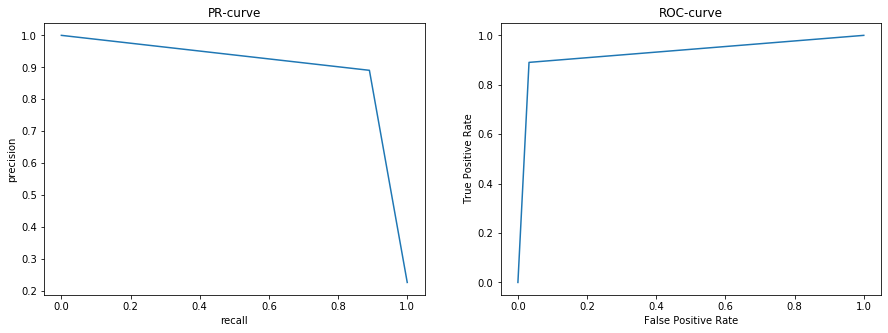

In [129]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
precision_array, recall_array, thresholds = precision_recall_curve(y_test, y_pred)
ax[0].plot(recall_array, precision_array)
ax[0].set_title('PR-curve')
ax[0].set_xlabel('recall')
ax[0].set_ylabel('precision')
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ax[1].plot(fpr, tpr)
ax[1].set_title('ROC-curve')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
fig.savefig('C:/Users/kiril/OneDrive/Рабочий стол/Дата Саенс/ProjectsDataScience/research_studies/2nd_year_bi/графики/pr_roc_curves.png')
plt.show()

In [130]:
data_test = X_test.merge(y_test, how='inner', left_index=True, right_index=True)

In [131]:
feat_cols = X_train.columns.tolist()
pca = PCA(n_components=27)
pca_result = pca.fit_transform(data_test[feat_cols].values)

In [132]:
data_test['pca-one'] = pca_result[:,0]
data_test['pca-two'] = pca_result[:,1]

In [133]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_test)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 282 samples in 0.000s...
[t-SNE] Computed neighbors for 282 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 282 / 282
[t-SNE] Mean sigma: 1.407674
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.547966
[t-SNE] KL divergence after 300 iterations: 0.446535


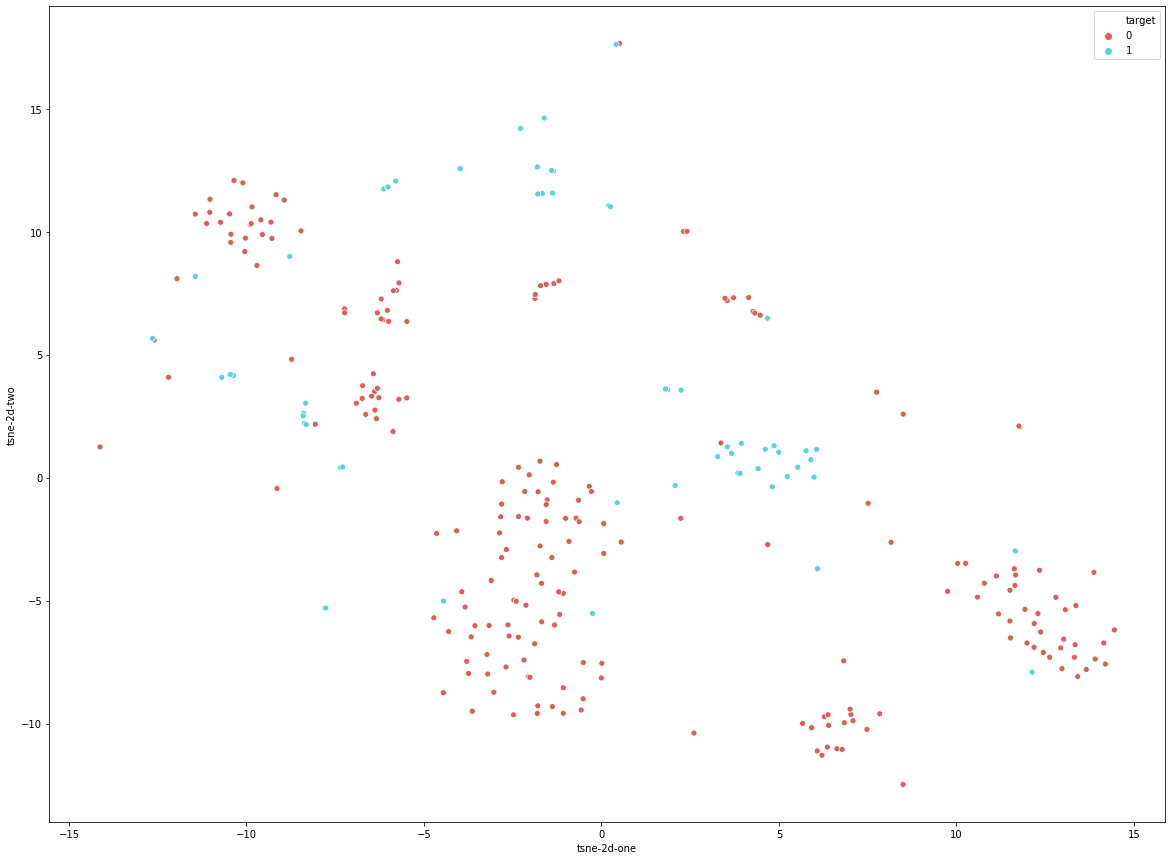

In [149]:
data_test['tsne-2d-one'] = tsne_results[:,0]
data_test['tsne-2d-two'] = tsne_results[:,1]
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=data_test,
    legend="full",
    ax=ax
)
fig.savefig('C:/Users/kiril/OneDrive/Рабочий стол/Дата Саенс/ProjectsDataScience/research_studies/2nd_year_bi/графики/t_sne_classes.png')
plt.show()

### 4.2. Важность признаков

In [135]:
feature_importances = pd.DataFrame(np.transpose(abs(final.coef_)), index=feat_cols, columns=['weight_of_features'])

In [136]:
feature_importances = feature_importances.sort_values(by='weight_of_features', ascending=False)

In [137]:
feature_importances

,weight_of_features
is_original,2.865909
discount_70.0,1.333952
discount_50.0,0.656126
discount_25.0,0.503602
is_preemptive_right,0.338510
citiz_Социалистическая Республика Вьетнам,0.304019
no_alternatives,0.295082
russian_points,0.279316
is_olympiad,0.243893
is_return_contract,0.235745


In [146]:
feature_importances.to_csv('C:/Users/kiril/OneDrive/Рабочий стол/Дата Саенс/ProjectsDataScience/research_studies/2nd_year_bi/данные/feat_imp.csv')

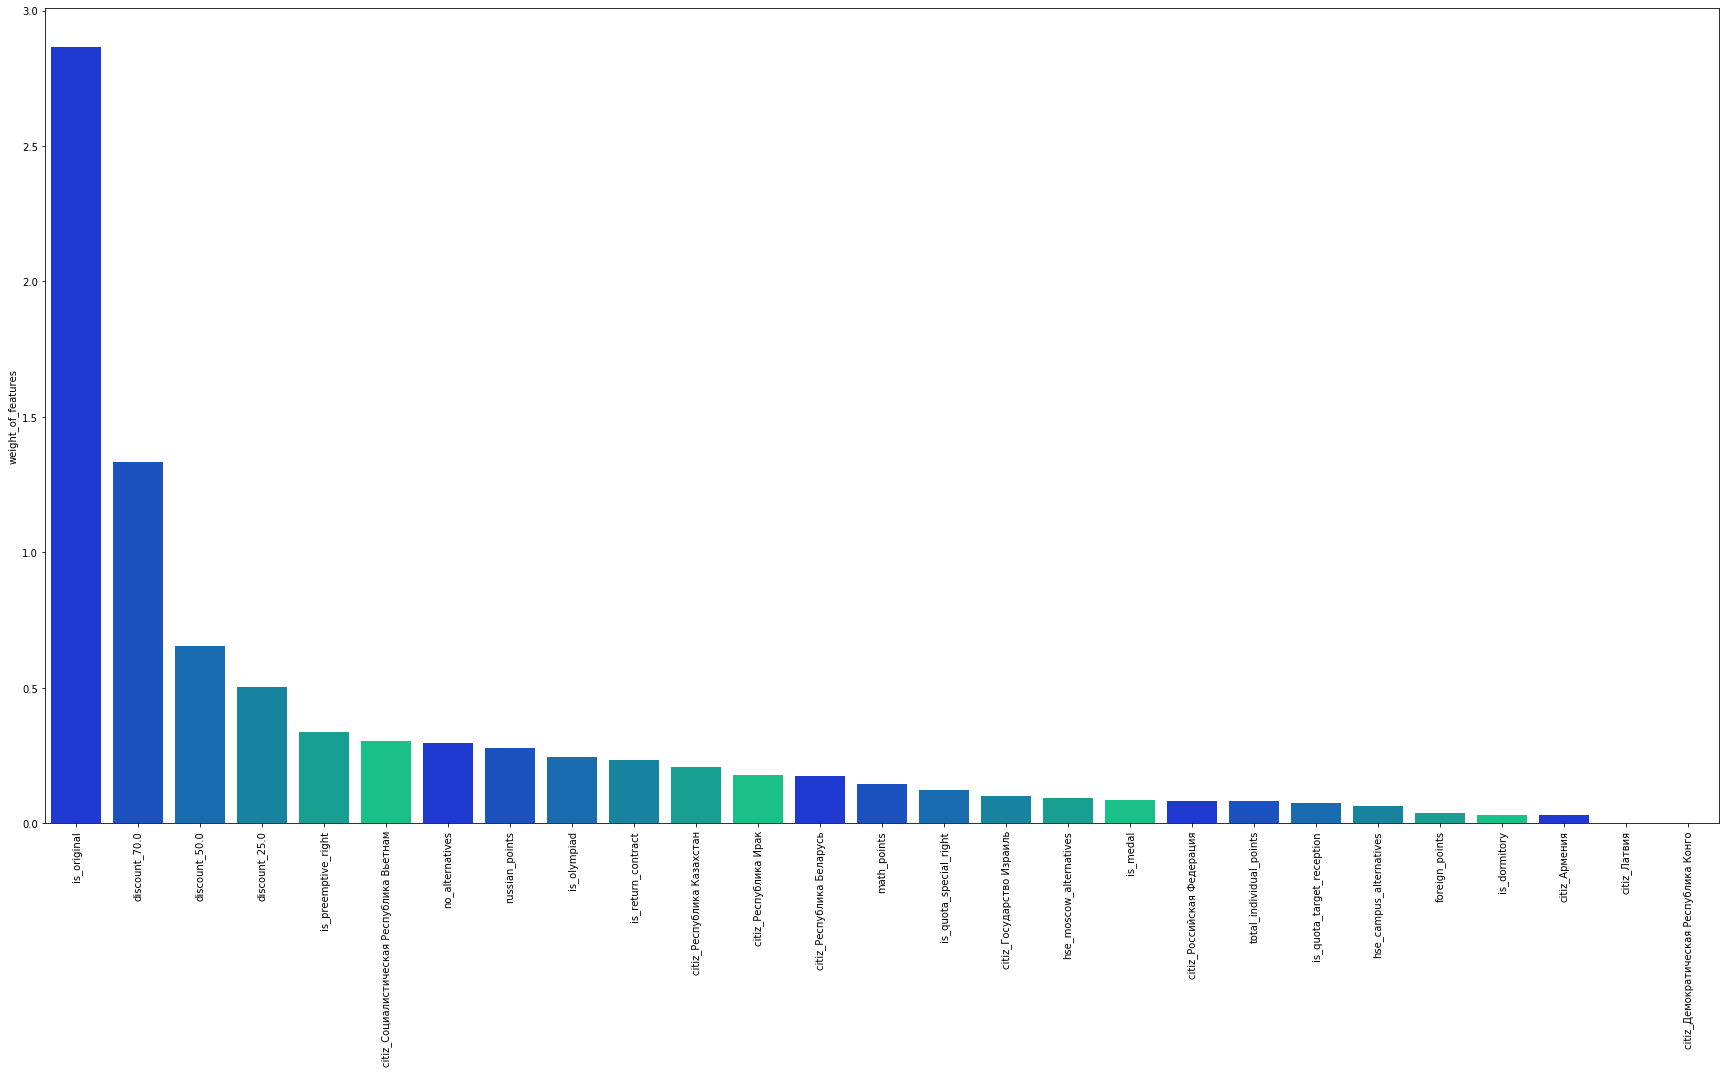

In [138]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 15))
sns.barplot(x=feature_importances.index, y=feature_importances['weight_of_features'], data=feature_importances, palette=sns.color_palette('winter'), ax=ax)
plt.xticks(rotation=90)
fig.savefig('C:/Users/kiril/OneDrive/Рабочий стол/Дата Саенс/ProjectsDataScience/research_studies/2nd_year_bi/графики/feat_imp.png')
plt.show()

#### Вывод

Очевидно, но получаем, что наиболее важными признаками являются is_original, discount_70, discount_50, discount_25, is_preemptive_right, citiz_Социалистическая Республика Вьетнам. Данные признаки имеют вес больше 0.3. Также следующие два признаки: no_altrentives и russian_points. Признаки, не имеющие никакого веса: citiz_Латвия, citiz_Демократическая Республика Конго.

## 5. Проверка на адекватность

In [139]:
dc = DummyClassifier()
model_dc = dc.fit(X_train, y_train)
y_pred_test = model_dc.predict(X_test)
print(f'Dummy Classifier (на тесте): {f1_recall(y_pred_test, y_test)}')

Dummy Classifier (на тесте): 0.22435897435897437


#### Вывод

Наша модель явно лучше, чем константная модель. Значит полученная модель адекватна в том плане, что может делать хорошие прогнозы.

## 6. Вывод

Таким образом, получили на примере данных абитуриентов программы Бизнес-информатики модель, которая позволяет оценивать вероятность поступления каждого из абитуриентов в университет. Модель логистической регрессии получила метрику качества на тестовых данных, равную 0.891, и также прошла проверку на адекватность. Наиболее важными признаками являются: is_original, discount_70, discount_50, discount_25, is_preemptive_right, citiz_Социалистическая Республика Вьетнам.

## 7. Сохранение модели

In [141]:
joblib.dump(final, 'C:/Users/kiril/OneDrive/Рабочий стол/Дата Саенс/ProjectsDataScience/research_studies/2nd_year_bi/модель/model')

['C:/Users/kiril/OneDrive/Рабочий стол/Дата Саенс/ProjectsDataScience/research_studies/2nd_year_bi/модель/model']